# Loading libraries

In [369]:
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt, atan2
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from geopy.geocoders import Nominatim
geolocator = Nominatim()

# models build
import xgboost as xgb

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, log_loss
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import cluster

# sys libs
from os import listdir
from os.path import isfile, join
import gc

# params/options tuning
pd.options.display.max_columns = 200
get_ipython().magic('matplotlib inline')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 16

# source and target
path_in = '/mnt/data/raw/'
path_out = '/mnt/data/'

# Load data

In [6]:
orders_drivers = pd.read_csv(path_in + 'orders_drivers.csv')

orders_drivers['order_datetime'] = pd.to_datetime(orders_drivers['order_datetime'], format = '%Y-%m-%d %H:%M:%S')
orders_drivers['rider_ftp_date_key'] = pd.to_datetime(orders_drivers['rider_ftp_date_key'], format = '%Y-%m-%d')
orders_drivers['driver_ftp_date_key'] = pd.to_datetime(orders_drivers['driver_ftp_date_key'], format = '%Y-%m-%d')

# Data markup

In [27]:
orders_drivers_work = orders_drivers.copy()

In [28]:
orders_drivers_work.head(2)

,order_gk,order_datetime,driver_gk,order_status,class_type,rider_total_cost,paid_with_prepaid,payment_type,ride_type,m_ride_duration,ride_distance_key,m_driver_wait_time,m_rating,rider_ftp_date_key,rider_main_device_desc,driver_ftp_date_key,driver_device_platform,total_loyalty_points,acquisition_channel_desc,action_before,previous_action_delta,churn_flag
972724,475212,2017-09-01 09:58:30,0,Completed,Premium,740.68,NaN,Cash,private,1469.0,9.9,116.0,NaN,2017-02-21,iOS,2016-03-17,Android,1840,MOBILE,NaT,NaT,0
972715,825677,2017-09-01 15:44:59,0,Completed,Premium,523.17,NaN,Credit_card,private,1027.0,6.2,122.0,5.0,2015-09-02,iOS,2016-03-17,Android,6045,NaN,2017-09-01 09:58:30,05:46:29,0


In [8]:
orders_drivers_work.sort_values(by=['driver_gk', 'order_datetime'], inplace=True)

In [9]:
orders_drivers_work['action_before'] = orders_drivers_work.groupby('driver_gk')['order_datetime'].shift(1)

In [10]:
orders_drivers_work['previous_action_delta'] = orders_drivers_work['order_datetime'] - orders_drivers_work['action_before']

In [64]:
orders_drivers_work['action_after'] = orders_drivers_work.groupby('driver_gk')['order_datetime'].shift(-1)
orders_drivers_work['next_action_delta'] = orders_drivers_work['action_after'] - orders_drivers_work['order_datetime']

In [66]:
orders_drivers_work[(orders_drivers_work['next_action_delta'] > pd.to_timedelta('0 days 01:00:00')) &\
               (orders_drivers_work['next_action_delta'] < pd.to_timedelta('14 days 00:00:00'))]['next_action_delta'].describe()

count                    494591
mean     0 days 08:16:50.075549
std      0 days 15:06:30.120460
min             0 days 01:00:01
25%             0 days 01:28:59
50%             0 days 02:35:28
75%      0 days 10:07:32.500000
max            13 days 21:23:03
Name: next_action_delta, dtype: object

In [68]:
churn_flag = lambda x: 1 if x > pd.to_timedelta('0 days 08:00:00') else 0

orders_drivers_work['churn_flag_fix'] = orders_drivers_work['next_action_delta'].apply(churn_flag)

In [29]:
orders_drivers_work[(orders_drivers_work['previous_action_delta'] > pd.to_timedelta('0 days 01:00:00')) &\
               (orders_drivers_work['previous_action_delta'] < pd.to_timedelta('14 days 00:00:00'))]['previous_action_delta'].describe()

count                    494591
mean     0 days 08:16:50.075549
std      0 days 15:06:30.120460
min             0 days 01:00:01
25%             0 days 01:28:59
50%             0 days 02:35:28
75%      0 days 10:07:32.500000
max            13 days 21:23:03
Name: previous_action_delta, dtype: object

In [12]:
churn_flag = lambda x: 1 if x > pd.to_timedelta('0 days 08:00:00') else 0

orders_drivers_work['churn_flag'] = orders_drivers_work['previous_action_delta'].apply(churn_flag)

In [16]:
orders_drivers_work[orders_drivers_work['churn_flag'] == 0]['previous_action_delta'].describe()

count                   1123011
mean     0 days 00:57:43.317270
std      0 days 01:20:35.112117
min             0 days 00:00:00
25%             0 days 00:00:13
50%             0 days 00:32:40
75%             0 days 01:15:01
max             0 days 08:00:00
Name: previous_action_delta, dtype: object

In [17]:
orders_drivers_work.columns

Index(['order_gk', 'order_datetime', 'driver_gk', 'order_status', 'class_type',
       'rider_total_cost', 'paid_with_prepaid', 'payment_type', 'ride_type',
       'm_ride_duration', 'ride_distance_key', 'm_driver_wait_time',
       'm_rating', 'rider_ftp_date_key', 'rider_main_device_desc',
       'driver_ftp_date_key', 'driver_device_platform', 'total_loyalty_points',
       'acquisition_channel_desc', 'action_before', 'previous_action_delta',
       'churn_flag'],
      dtype='object')

In [19]:
%%time
# Разметка сессий

session_id = 0
sessions_list = []

for index in range(len(orders_drivers_work)):
    new_line = {}
    row = orders_drivers_work.iloc[index]
    
    new_line['order_gk'] = row['order_gk']
    new_line['driver_gk'] = row['driver_gk']
    new_line['order_datetime'] = row['order_datetime']
    new_line['previous_action_delta'] = row['previous_action_delta'] 
    
    if row['previous_action_delta'] <= pd.to_timedelta('0 days 08:00:00'):
        session_id = session_id
    elif row['previous_action_delta'] > pd.to_timedelta('0 days 08:00:00'):
        session_id += 1
    else:
        session_id = 0
    
    new_line['session_id'] = session_id
    
    sessions_list.append(new_line)
    
#sessions = pd.DataFrame( sessions_list, columns=['driver_gk', 'order_datetime', 'order_gk', 'previous_action_delta', 'session_id'])

#sessions.to_csv(path_in + 'sessions.csv', sep=',', index=False)

CPU times: user 7min 27s, sys: 540 ms, total: 7min 28s
Wall time: 7min 28s


In [21]:
sessions = pd.DataFrame( sessions_list, columns=['driver_gk', 'order_datetime', 'order_gk', 'previous_action_delta', 'session_id'])

In [32]:
orders_drivers_work = orders_drivers_work.merge(sessions[['order_gk', 'session_id']],\
                                                how='inner',\
                                                on=['order_gk'])

# create dataset

In [330]:
orders_drivers_work.columns

Index(['order_gk', 'order_datetime', 'driver_gk', 'order_status', 'class_type',
       'rider_total_cost', 'paid_with_prepaid', 'payment_type', 'ride_type',
       'm_ride_duration', 'ride_distance_key', 'm_driver_wait_time',
       'm_rating', 'rider_ftp_date_key', 'rider_main_device_desc',
       'driver_ftp_date_key', 'driver_device_platform', 'total_loyalty_points',
       'acquisition_channel_desc', 'action_before', 'previous_action_delta',
       'churn_flag', 'session_id', 'session_total_rank',
       'session_completed_rank', 'session_cancelled_rank',
       'session_rejected_rank', 'action_after', 'next_action_delta',
       'churn_flag_fix', 'class_type_code', 'ride_type_code',
       'order_status_code', 'payment_type_code',
       'acquisition_channel_desc_code', 'mean_reject', 'order_day_of_week',
       'order_hour', 'total_value', 'total_ride_duration', 'mean_value_reject',
       'total_value_bigger', 'session_time_length', 'mean_session_time_length',
       'mean_sessi

In [36]:
orders_drivers_work['order_status'].unique()

array(['Completed', 'Cancelled', 'Rejected'], dtype=object)

In [38]:
%%time
orders_drivers_work['for_total_sum'] = 1

orders_drivers_work['for_completed_sum'] = 1
orders_drivers_work['for_completed_sum'] = orders_drivers_work['order_status'].apply(lambda x: 1 if x == 'Completed' else 0)

orders_drivers_work['for_cancelled_sum'] = 1
orders_drivers_work['for_cancelled_sum'] = orders_drivers_work['order_status'].apply(lambda x: 1 if x == 'Cancelled' else 0)

orders_drivers_work['for_rejected_sum'] = 1
orders_drivers_work['for_rejected_sum'] = orders_drivers_work['order_status'].apply(lambda x: 1 if x == 'Rejected' else 0)

orders_drivers_work['session_total_rank'] = orders_drivers_work.groupby(['driver_gk', 'session_id'])['for_total_sum'].cumsum()
orders_drivers_work['session_completed_rank'] = orders_drivers_work.groupby(['driver_gk', 'session_id'])['for_completed_sum'].cumsum()
orders_drivers_work['session_cancelled_rank'] = orders_drivers_work.groupby(['driver_gk', 'session_id'])['for_cancelled_sum'].cumsum()
orders_drivers_work['session_rejected_rank'] = orders_drivers_work.groupby(['driver_gk', 'session_id'])['for_rejected_sum'].cumsum()

del orders_drivers_work['for_total_sum']
del orders_drivers_work['for_completed_sum']
del orders_drivers_work['for_cancelled_sum']
del orders_drivers_work['for_rejected_sum']

gc.collect()

1
2
3
CPU times: user 2.61 s, sys: 156 ms, total: 2.77 s
Wall time: 2.76 s


In [150]:
orders_drivers_work['class_type'] = pd.Categorical(orders_drivers_work.loc[orders_drivers_work.index, 'class_type'])
orders_drivers_work['class_type_code'] = orders_drivers_work['class_type'].cat.codes

orders_drivers_work['ride_type'] = pd.Categorical(orders_drivers_work.loc[orders_drivers_work.index, 'ride_type'])
orders_drivers_work['ride_type_code'] = orders_drivers_work['ride_type'].cat.codes

orders_drivers_work['order_status'] = pd.Categorical(orders_drivers_work.loc[orders_drivers_work.index, 'order_status'])
orders_drivers_work['order_status_code'] = orders_drivers_work['order_status'].cat.codes

orders_drivers_work['payment_type'] = pd.Categorical(orders_drivers_work.loc[orders_drivers_work.index, 'payment_type'])
orders_drivers_work['payment_type_code'] = orders_drivers_work['payment_type'].cat.codes

orders_drivers_work['acquisition_channel_desc'] = pd.Categorical(orders_drivers_work.loc[orders_drivers_work.index, 'acquisition_channel_desc'])
orders_drivers_work['acquisition_channel_desc_code'] = orders_drivers_work['acquisition_channel_desc'].cat.codes

In [211]:
# Парсинг дат
orders_drivers_work['order_day_of_week'] = orders_drivers_work['order_datetime'].dt.dayofweek
orders_drivers_work['order_hour'] = orders_drivers_work['order_datetime'].dt.hour

In [238]:
orders_drivers_work['total_value'] = orders_drivers_work.groupby(['driver_gk', 'session_id'])['rider_total_cost'].cumsum()
orders_drivers_work['total_ride_duration'] = orders_drivers_work.groupby(['driver_gk', 'session_id'])['m_ride_duration'].cumsum()

In [275]:
window_split = '2017-09-23 00:00:00'

train_dataset = orders_drivers_work[(orders_drivers_work['order_datetime'] < window_split) &\
                                    (orders_drivers_work['driver_gk'] != 2561)].copy()

In [248]:
temp = pd.DataFrame(train_dataset[train_dataset['churn_flag_fix'] == 1].groupby('driver_gk')['total_value'].mean())\
         .rename(columns={'total_value': 'mean_value_reject'})
temp.reset_index(inplace=True)

orders_drivers_work= orders_drivers_work.merge(temp, how='left', on='driver_gk')
orders_drivers_work.loc[orders_drivers_work[orders_drivers_work['mean_value_reject'].isnull()].index, 'mean_value_reject'] = \
    train_dataset[train_dataset['churn_flag_fix'] == 1]['total_value'].mean()

is_bigger = lambda row: 1 if row[0] < row[1] else 0
orders_drivers_work['total_value_bigger'] = orders_drivers_work[['total_value', 'mean_value_reject']].apply(is_bigger, axis=1)

In [290]:
train_dataset = orders_drivers_work[orders_drivers_work['driver_gk'] != 2561].copy()

temp = train_dataset.groupby(['driver_gk', 'session_id'])['order_datetime'].agg(['min', 'max'])
temp['diff'] = temp['max'] - temp['min']
temp['session_time_length'] = round(temp['diff'].dt.total_seconds()/3600, 2)

In [293]:
orders_drivers_work= orders_drivers_work.merge(temp, how='left', left_on=['driver_gk', 'session_id'], right_index = True)

del orders_drivers_work['min']
del orders_drivers_work['max']
del orders_drivers_work['diff']

In [298]:
window_split = '2017-09-23 00:00:00'

train_dataset = orders_drivers_work[(orders_drivers_work['order_datetime'] < window_split) &\
                                    (orders_drivers_work['driver_gk'] != 2561)].copy()

temp = pd.DataFrame(train_dataset[train_dataset['churn_flag_fix'] == 1].groupby('driver_gk')['session_time_length'].mean())\
         .rename(columns={'session_time_length': 'mean_session_time_length'})
temp.reset_index(inplace=True)

orders_drivers_work= orders_drivers_work.merge(temp, how='left', on='driver_gk')
orders_drivers_work.loc[orders_drivers_work[orders_drivers_work['mean_session_time_length'].isnull()].index, 'mean_session_time_length'] = \
    train_dataset[train_dataset['churn_flag_fix'] == 1]['session_time_length'].mean()

is_bigger = lambda row: 1 if row[0] < row[1] else 0
orders_drivers_work['mean_session_time_length_bigger'] = orders_drivers_work[['session_time_length', 'mean_session_time_length']].apply(is_bigger, axis=1)

In [331]:
window_split = '2017-09-23 00:00:00'

train_dataset = orders_drivers_work[(orders_drivers_work['order_datetime'] < window_split) &\
                                    (orders_drivers_work['driver_gk'] != 2561)].copy()

In [ ]:
temp = pd.DataFrame(train_dataset[train_dataset['churn_flag_fix'] == 1].groupby('driver_gk')['total_value'].mean())\
         .rename(columns={'total_value': 'mean_value_reject'})
temp.reset_index(inplace=True)

orders_drivers_work= orders_drivers_work.merge(temp, how='left', on='driver_gk')
orders_drivers_work.loc[orders_drivers_work[orders_drivers_work['mean_value_reject'].isnull()].index, 'mean_value_reject'] = \
    train_dataset[train_dataset['churn_flag_fix'] == 1]['total_value'].mean()

is_bigger = lambda row: 1 if row[0] < row[1] else 0
orders_drivers_work['total_value_bigger'] = orders_drivers_work[['total_value', 'mean_value_reject']].apply(is_bigger, axis=1)

In [ ]:
window_split = '2017-09-23 00:00:00'

train_dataset = orders_drivers_work[(orders_drivers_work['order_datetime'] < window_split) &\
                                    (orders_drivers_work['driver_gk'] != 2561)].copy()

temp = pd.DataFrame(train_dataset.groupby('driver_gk')['churn_flag_fix'].mean())\
         .rename(columns={'churn_flag_fix': 'mean_reject'})
temp.reset_index(inplace=True)
orders_drivers_work= orders_drivers_work.merge(temp, how='left', on='driver_gk')

In [332]:
orders_drivers_work['session_completion_rate'] = orders_drivers_work['session_completed_rank']/orders_drivers_work['session_total_rank']

In [ ]:
temp = orders_drivers_work[orders_drivers_work['churn_flag_fix'] == 1]]

In [340]:
orders_drivers_work['rides_per_1_GH'] = orders_drivers_work['session_time_length']/orders_drivers_work['session_completed_rank']

In [352]:
orders_drivers_work[orders_drivers_work['churn_flag_fix'] == 1]['session_time_length'].describe()

count    140286.000000
mean          7.308896
std           6.964341
min           0.000000
25%           2.100000
50%           6.350000
75%          10.700000
max         220.490000
Name: session_time_length, dtype: float64

In [361]:
orders_drivers_work[orders_drivers_work['driver_gk']== 2561]['order_status'].value_counts()

Rejected     191392
Cancelled    136306
Completed         0
Name: order_status, dtype: int64

In [360]:
orders_drivers_work[(orders_drivers_work['churn_flag_fix'] == 1) &\
                                     (orders_drivers_work['session_time_length'] < 24) &\
                                     (orders_drivers_work['session_time_length'] > 1)]\
                    .groupby('driver_gk')['session_time_length'].mean().describe()

count    7460.000000
mean        8.494128
std         3.215912
min         2.015385
25%         6.419083
50%         7.886978
75%         9.697000
max        22.940000
Name: session_time_length, dtype: float64

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


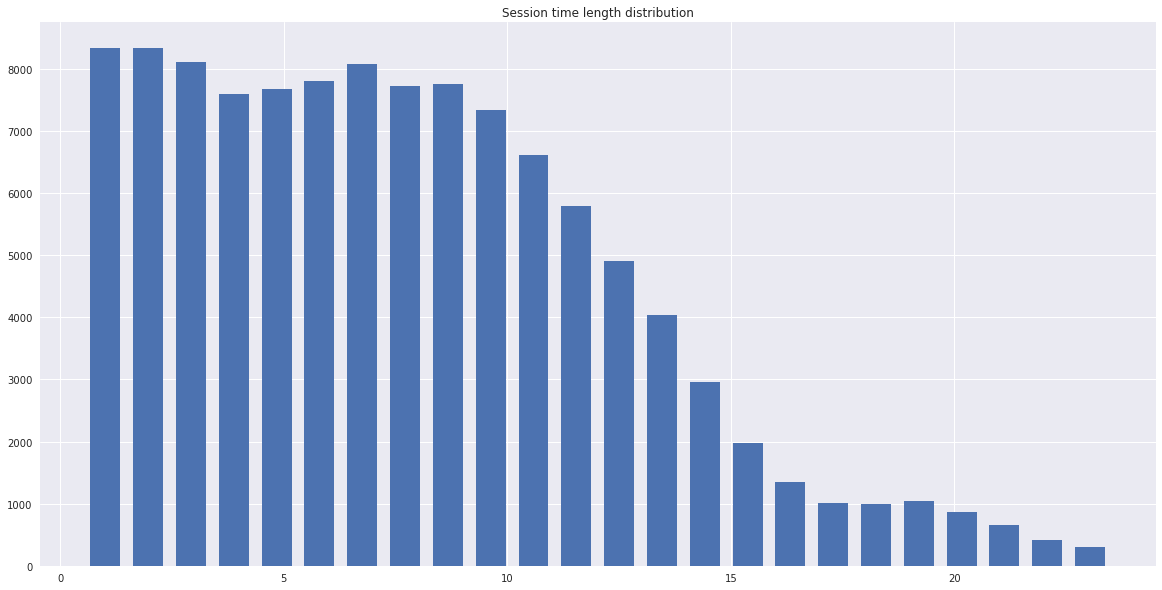

In [357]:
s_DriverOffers = orders_drivers_work[(orders_drivers_work['churn_flag_fix'] == 1) &\
                                     (orders_drivers_work['session_time_length'] < 24) &\
                                     (orders_drivers_work['session_time_length'] > 1)]['session_time_length']
H_DriverOffers, Bins_DriverOffers = np.histogram(s_DriverOffers, 24)

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(Bins_DriverOffers[:-1], H_DriverOffers, width=0.7 * (Bins_DriverOffers[1] - Bins_DriverOffers[0]))
plt.title("Sessions time length distribution")

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


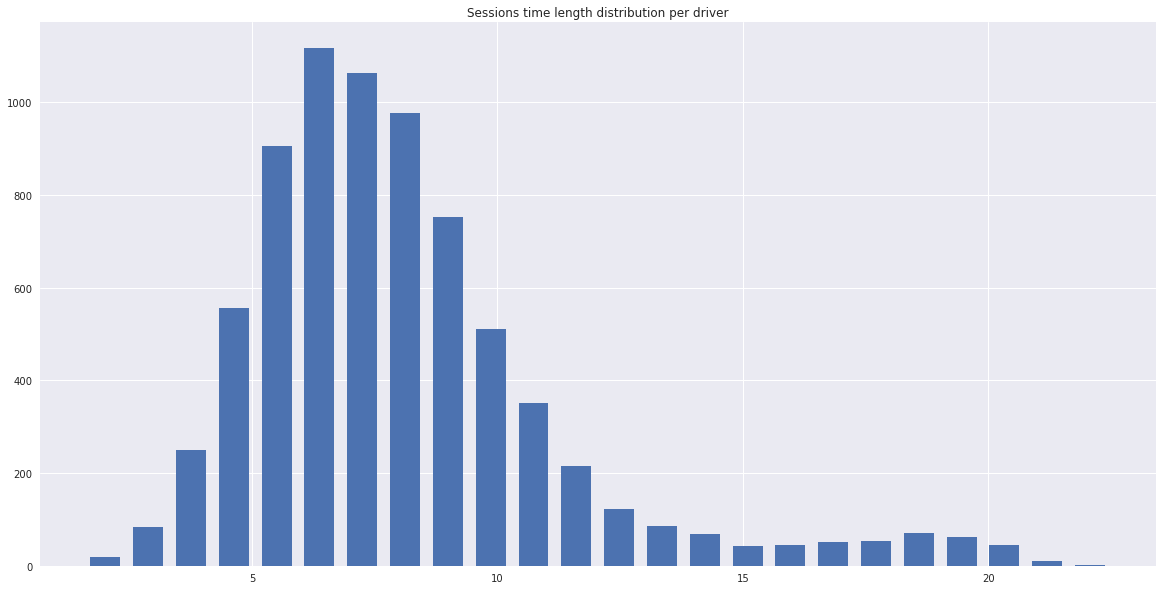

In [358]:
s_DriverOffers = orders_drivers_work[(orders_drivers_work['churn_flag_fix'] == 1) &\
                                     (orders_drivers_work['session_time_length'] < 24) &\
                                     (orders_drivers_work['session_time_length'] > 1)]\
                                    .groupby('driver_gk')['session_time_length'].mean()
H_DriverOffers, Bins_DriverOffers = np.histogram(s_DriverOffers, 24)

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(Bins_DriverOffers[:-1], H_DriverOffers, width=0.7 * (Bins_DriverOffers[1] - Bins_DriverOffers[0]))
plt.title("Sessions time length distribution per driver")

In [345]:
orders_drivers_work[orders_drivers_work['churn_flag_fix'] != 1]['rides_per_1_GH'].describe()

count    8.026550e+05
mean              inf
std               NaN
min      0.000000e+00
25%      1.660000e+00
50%      2.726000e+00
75%      5.150000e+00
max               inf
Name: rides_per_1_GH, dtype: float64

In [344]:
orders_drivers_work[orders_drivers_work['churn_flag_fix'] == 1]['rides_per_1_GH'].describe()

count    1.381370e+05
mean              inf
std               NaN
min      0.000000e+00
25%      7.112500e-01
50%      1.170000e+00
75%      1.785000e+00
max               inf
Name: rides_per_1_GH, dtype: float64

In [ ]:
window_split = '2017-09-23 00:00:00'

train_dataset = orders_drivers_work[(orders_drivers_work['order_datetime'] < window_split) &\
                                    (orders_drivers_work['driver_gk'] != 2561)].copy()

In [ ]:
Utilization
How driver is utilized with our business
(a) Rides per 1 GH
(b) % time in ride in 1 GH

In [ ]:
'session_total_rank',
       'session_completed_rank', 'session_cancelled_rank',
       'session_rejected_rank'

# Baseline

In [192]:
temp = pd.DataFrame(train_dataset.groupby('driver_gk')['churn_flag_fix'].mean())\
         .rename(columns={'churn_flag_fix': 'mean_reject'})
temp.reset_index(inplace=True)
orders_drivers_work= orders_drivers_work.merge(temp, how='left', on='driver_gk')

In [350]:
roc_auc_score(train_dataset['churn_flag_fix'], train_dataset['mean_reject'])

0.67416151506138111

In [169]:
orders_drivers_work['driver_gk'].describe()

count    1.270765e+06
mean     3.430132e+03
std      1.933318e+03
min      0.000000e+00
25%      2.501000e+03
50%      2.561000e+03
75%      4.958000e+03
max      7.467000e+03
Name: driver_gk, dtype: float64

# xgboost

In [318]:
orders_drivers_work.columns

Index(['order_gk', 'order_datetime', 'driver_gk', 'order_status', 'class_type',
       'rider_total_cost', 'paid_with_prepaid', 'payment_type', 'ride_type',
       'm_ride_duration', 'ride_distance_key', 'm_driver_wait_time',
       'm_rating', 'rider_ftp_date_key', 'rider_main_device_desc',
       'driver_ftp_date_key', 'driver_device_platform', 'total_loyalty_points',
       'acquisition_channel_desc', 'action_before', 'previous_action_delta',
       'churn_flag', 'session_id', 'tmp_total_sum', 'session_total_rank',
       'session_completed_rank', 'session_cancelled_rank',
       'session_rejected_rank', 'action_after', 'next_action_delta',
       'churn_flag_fix', 'class_type_code', 'ride_type_code',
       'order_status_code', 'payment_type_code',
       'acquisition_channel_desc_code', 'mean_reject', 'order_day_of_week',
       'order_hour', 'total_value', 'total_ride_duration', 'mean_value_reject',
       'total_value_bigger', 'session_time_length', 'mean_session_time_length',
 

In [372]:
len(x_list)

22

In [346]:
x_list = ['session_total_rank', 'session_completed_rank', 'session_cancelled_rank', 'session_rejected_rank', 'class_type_code',\
          'ride_type_code', 'order_status_code', 'rider_total_cost', 'payment_type_code', 'paid_with_prepaid', 'driver_gk',\
          'mean_reject', 'order_day_of_week', 'order_hour', 'm_ride_duration', 'total_value', 'total_ride_duration', 'total_value_bigger',\
          'mean_session_time_length_bigger', 'session_time_length', 'session_completion_rate', 'rides_per_1_GH']

In [362]:
window_split = '2017-09-23 00:00:00'

train_dataset = orders_drivers_work[(orders_drivers_work['order_datetime'] < window_split) &\
                                    (orders_drivers_work['driver_gk'] != 2561)].copy()
X_test = orders_drivers_work[(orders_drivers_work['order_datetime'] >= window_split) &\
                             (orders_drivers_work['driver_gk'] != 2561)][x_list]
y_test = orders_drivers_work[(orders_drivers_work['order_datetime'] >= window_split) &\
                             (orders_drivers_work['driver_gk'] != 2561)]['churn_flag_fix']


X_train, X_valid, y_train, y_valid = train_test_split(train_dataset[x_list],\
                                                      train_dataset['churn_flag_fix'],\
                                                      random_state=42,\
                                                      test_size = 0.2,\
                                                      stratify = train_dataset['churn_flag_fix'])

dtrain = xgb.DMatrix( X_train, label=y_train)
dvalid = xgb.DMatrix( X_valid, label=y_valid)
dtest = xgb.DMatrix( X_test, label=y_test)

In [389]:
print('Classes distribution train:\n 1 - %d, %f  \n 0 - %d, %f'%(y_train.value_counts()[1],\
                                                                y_train.value_counts()[1]/y_train.count(),\
                                                                y_train.value_counts()[0],\
                                                                y_train.value_counts()[0]/y_train.count())) 

print('Classes distribution validation:\n 1 - %d, %f  \n 0 - %d, %f'%(y_valid.value_counts()[1],\
                                                                y_valid.value_counts()[1]/y_valid.count(),\
                                                                y_valid.value_counts()[0],\
                                                                y_valid.value_counts()[0]/y_valid.count())) 

print('Classes distribution test:\n 1 - %d, %f  \n 0 - %d, %f'%(y_test.value_counts()[1],\
                                                                y_test.value_counts()[1]/y_test.count(),\
                                                                y_test.value_counts()[0],\
                                                                y_test.value_counts()[0]/y_test.count())) 

Classes distribution train:
 1 - 91237, 0.151144  
 0 - 512404, 0.848856
Classes distribution validation:
 1 - 22809, 0.151142  
 0 - 128102, 0.848858
Classes distribution test:
 1 - 26240, 0.139193  
 0 - 162275, 0.860807


In [365]:
y_train.value_counts()

0    512404
1     91237
Name: churn_flag_fix, dtype: int64

In [366]:
y_valid.value_counts()

0    128102
1     22809
Name: churn_flag_fix, dtype: int64

In [367]:
y_test.value_counts()

0    162275
1     26240
Name: churn_flag_fix, dtype: int64

In [373]:
param = {'max_depth':9, 'min_child_weight': 5, 'eta':0.1, 'subsample': 0.8, 'alpha': 0.1, 'silent':1,\
         'objective':'binary:logistic', 'eval_metric': 'auc'}
evallist  = [(dvalid,'eval'), (dtrain,'train')]
plst = param.items()
num_round = 50

bst = xgb.train( plst, dtrain, num_round, evallist )

[0]	eval-auc:0.895038	train-auc:0.897541
[1]	eval-auc:0.899218	train-auc:0.901573
[2]	eval-auc:0.90271	train-auc:0.905209
[3]	eval-auc:0.903558	train-auc:0.906223
[4]	eval-auc:0.904669	train-auc:0.907716
[5]	eval-auc:0.90548	train-auc:0.908705
[6]	eval-auc:0.906224	train-auc:0.909659
[7]	eval-auc:0.906906	train-auc:0.910418
[8]	eval-auc:0.907353	train-auc:0.911124
[9]	eval-auc:0.908023	train-auc:0.911926
[10]	eval-auc:0.908579	train-auc:0.912543
[11]	eval-auc:0.909093	train-auc:0.913171
[12]	eval-auc:0.909642	train-auc:0.913762
[13]	eval-auc:0.909952	train-auc:0.914141
[14]	eval-auc:0.910877	train-auc:0.915267
[15]	eval-auc:0.911868	train-auc:0.916454
[16]	eval-auc:0.912199	train-auc:0.916822
[17]	eval-auc:0.913236	train-auc:0.917924
[18]	eval-auc:0.913514	train-auc:0.918299
[19]	eval-auc:0.913747	train-auc:0.918529
[20]	eval-auc:0.913996	train-auc:0.918888
[21]	eval-auc:0.914144	train-auc:0.91908
[22]	eval-auc:0.914857	train-auc:0.919895
[23]	eval-auc:0.915192	train-auc:0.920295
[24]	

In [371]:
# score признаков модели
df_score = pd.DataFrame(list(bst.get_fscore().items()), columns=['feature','importance']).\
               sort_values('importance', ascending=False)
df_score.head(20)

,feature,importance
1,rides_per_1_GH,285
4,mean_reject,268
8,session_time_length,156
11,session_total_rank,124
14,order_hour,108
3,total_ride_duration,78
0,total_value,76
10,rider_total_cost,72
6,session_completion_rate,57
12,session_cancelled_rank,53


In [374]:
roc_auc_score(y_test, bst.predict(dtest))

0.88706549429604231

In [273]:
X_train.describe()

,session_total_rank,session_completed_rank,session_cancelled_rank,session_rejected_rank,class_type_code,ride_type_code,order_status_code,rider_total_cost,payment_type_code,paid_with_prepaid,driver_gk,mean_reject,order_day_of_week,order_hour,m_ride_duration,total_value,total_ride_duration,total_value_bigger
count,528186.000000,528186.000000,528186.000000,528186.000000,528186.000000,528186.000000,528186.000000,494810.000000,528186.000000,20919.000000,528186.000000,528186.000000,528186.000000,528186.000000,444837.000000,494810.000000,444837.000000,528186.000000
mean,6.106752,5.042430,1.064114,0.000208,1.644601,2.874461,0.841584,491.351781,0.897951,209.482224,3730.149375,0.151183,3.097770,13.805239,1659.203207,2532.761347,8155.574878,0.715971
std,6.056158,5.057317,1.708822,0.014430,1.523286,0.339787,0.365234,516.019923,0.574020,229.798102,2164.876142,0.082830,1.893072,6.393551,1338.987650,2557.017350,7926.298484,0.450951
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,0.000000,0.000000,0.000000,3.000000,1.000000,224.580000,1.000000,100.000000,1858.000000,0.090090,1.000000,9.000000,770.000000,894.910000,2926.000000,0.000000
50%,4.000000,4.000000,1.000000,0.000000,2.000000,3.000000,1.000000,390.680000,1.000000,150.000000,3736.000000,0.133333,3.000000,15.000000,1351.000000,1864.285000,6040.000000,1.000000
75%,8.000000,7.000000,1.000000,0.000000,3.000000,3.000000,1.000000,627.385000,1.000000,230.000000,5609.000000,0.194175,5.000000,19.000000,2178.000000,3376.270000,10998.000000,1.000000
max,140.000000,120.000000,64.000000,1.000000,7.000000,3.000000,2.000000,66810.170000,2.000000,17307.000000,7467.000000,0.761905,6.000000,23.000000,35974.000000,70775.410000,196764.000000,1.000000


In [159]:
train_dataset.groupby(['churn_flag_fix'])['session_total_rank'].describe()

,count,mean,std,min,25%,50%,75%,max
churn_flag_fix,,,,,,,,
0,640506.0,6.051395,6.160408,1.0,2.0,4.0,8.0,139.0
1,114046.0,6.458192,5.530466,1.0,3.0,5.0,9.0,140.0


In [160]:
train_dataset.groupby(['churn_flag_fix'])['session_completed_rank'].describe()

,count,mean,std,min,25%,50%,75%,max
churn_flag_fix,,,,,,,,
0,640506.0,4.978117,5.142074,0.0,2.0,4.0,7.0,120.0
1,114046.0,5.434763,4.642221,0.0,2.0,4.0,7.0,118.0


In [161]:
train_dataset.groupby(['churn_flag_fix'])['session_cancelled_rank'].describe()

,count,mean,std,min,25%,50%,75%,max
churn_flag_fix,,,,,,,,
0,640506.0,1.073078,1.725642,0.0,0.0,1.0,1.0,64.0
1,114046.0,1.023219,1.574002,0.0,0.0,1.0,1.0,64.0


In [162]:
train_dataset.groupby(['churn_flag_fix'])['session_rejected_rank'].describe()

,count,mean,std,min,25%,50%,75%,max
churn_flag_fix,,,,,,,,
0,640506.0,0.00020,0.014135,0.0,0.0,0.0,0.0,1.0
1,114046.0,0.00021,0.014505,0.0,0.0,0.0,0.0,1.0


# Анализ качества модели

## Precision/recall validation

In [323]:
#рисуем precision&recall
y_pred = bst.predict(dvalid) 
#y_pred = 1-y_pred

precision, recall, thresholds = precision_recall_curve(y_valid, y_pred)
thresholds = np.append(thresholds, [1])

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


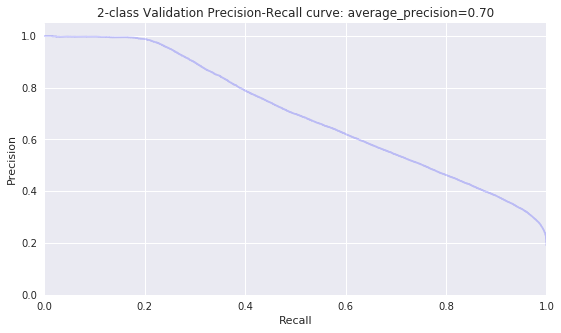

In [324]:
average_precision = average_precision_score(y_valid, y_pred)

fig = plt.figure(figsize=(9,5))
#plt.step(recall, precision, color='b', alpha=0.2, where='post')
#plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.plot(recall, precision, alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Validation Precision-Recall curve: average_precision={0:0.2f}'.format(average_precision))

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


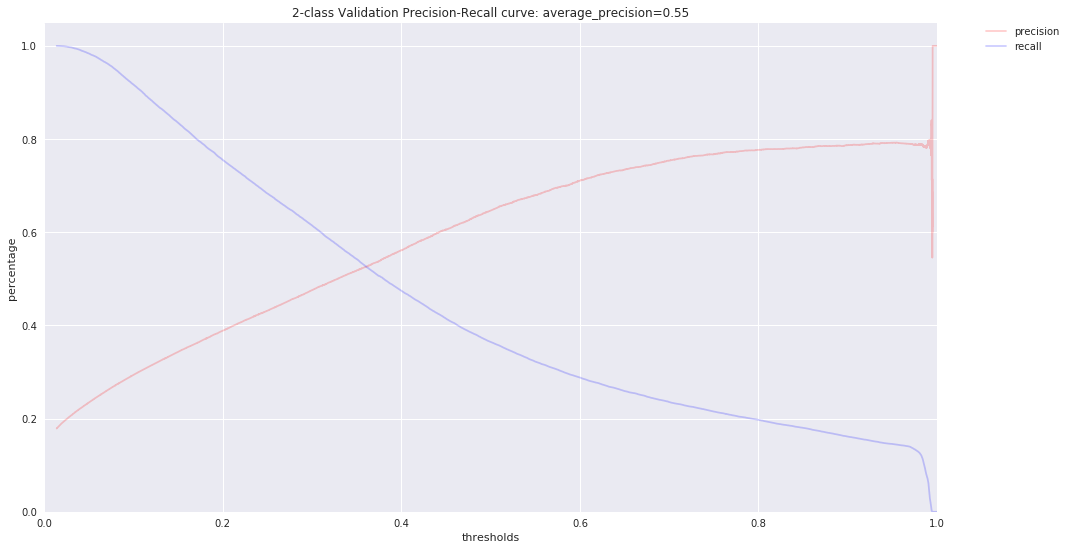

In [375]:
fig = plt.figure(figsize=(16,9))
plt.plot(thresholds, precision, alpha=0.2, label='precision', color='r') # precision
plt.plot(thresholds, recall, alpha=0.2, label='recall', color='b') # recall
plt.xlabel('thresholds')
plt.ylabel('percentage')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Validation Precision-Recall curve: average_precision={0:0.2f}'.format(average_precision))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Precision/recall test

In [326]:
#рисуем precision&recall
y_pred = bst.predict(dtest) 
#y_pred = 1-y_pred

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
thresholds = np.append(thresholds, [1])

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


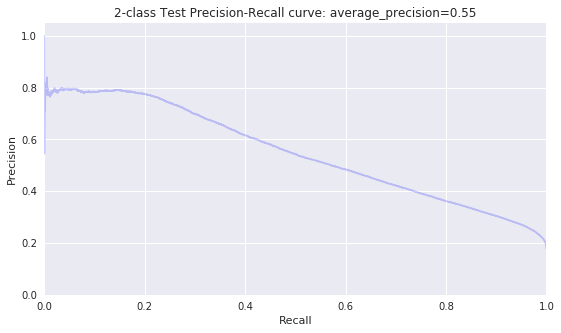

In [327]:
average_precision = average_precision_score(y_test, y_pred)

fig = plt.figure(figsize=(9,5))
#plt.step(recall, precision, color='b', alpha=0.2, where='post')
#plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.plot(recall, precision, alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
FONT_SIZE = 28
plt.rc('font', size=FONT_SIZE)
plt.rc('axes', titlesize=FONT_SIZE)plt.title('2-class Test Precision-Recall curve: average_precision={0:0.2f}'.format(average_precision))

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


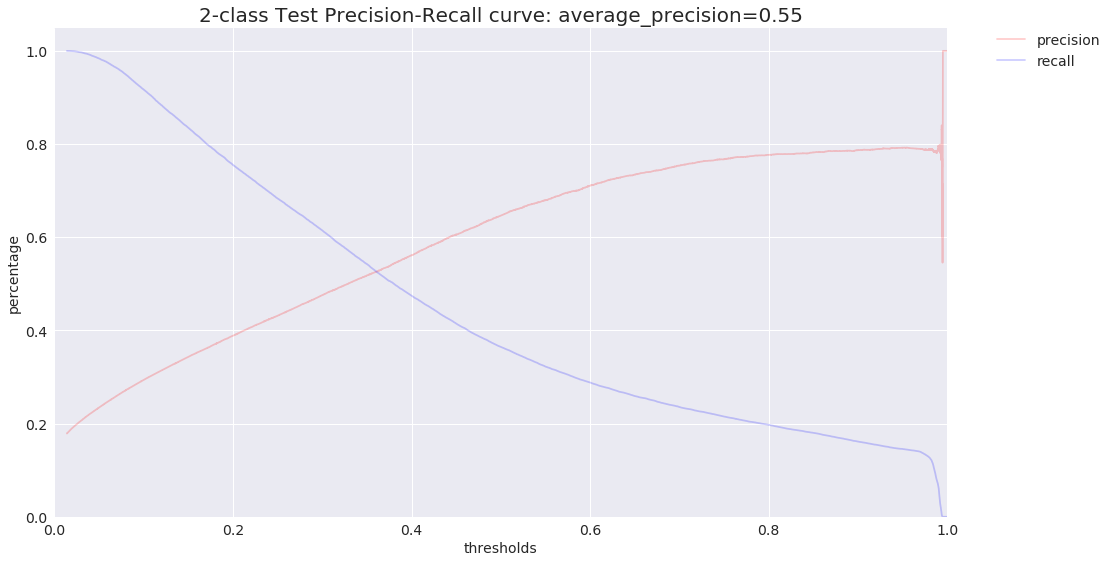

In [388]:
FONT_SIZE = 20
plt.rc('font', size=FONT_SIZE)
plt.rc('axes', titlesize=FONT_SIZE)

FONT_SIZE = 14
plt.rc('xtick', labelsize=FONT_SIZE) 
plt.rc('ytick', labelsize=FONT_SIZE)

fig = plt.figure(figsize=(16,9))

plt.plot(thresholds, precision, alpha=0.2, label='precision', color='r') # precision
plt.plot(thresholds, recall, alpha=0.2, label='recall', color='b') # recall
plt.xlabel('thresholds', fontsize=14)
plt.ylabel('percentage', fontsize=14)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Test Precision-Recall curve: average_precision={0:0.2f}'.format(average_precision))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=14)

plt.show()